In [2]:
library(tidyverse)
library(repr)
library(tidymodels)
library(RColorBrewer)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

In the Algerian regions(Northern Africa) of Bejaia and Sidi Bel-abbes during the period between June 2012 and September 2012, forest fires ravaged an estimated 20,000 hectares of land. The paper “Predicting Forest Fire in Algeria Using Data Mining Techniques: Case Study of the Decision Tree Algorithm”, written by Faroudja Abid and Nouma Izeboudjen, proposes a method of predicting forest fires based on meteorological data and environmental factors.

Our project aims to wrangle the data in a way such that we can use it to predict whether or not there will be a forest fire, based on the dependent variables.


In [19]:
forestfire_data <- read_csv("Algerian_forest_fires_dataset_UPDATE.csv", skip = 1, 
                            col_types = "ncnnnnnnnnnnnf")%>%
                mutate(month = case_when(month == '06' ~ "June",
                                   month == '07' ~ "Jul",
                                   month == '08' ~ "Aug",
                                   month == '09' ~ "Sep"))%>%
                filter(Classes != 'Classes')

nrow(forestfire_data)

Warning message:
“16 parsing failures.
row         col   expected      actual                                       file
123 day         a number   -           'Algerian_forest_fires_dataset_UPDATE.csv'
123 NA          14 columns 1 columns   'Algerian_forest_fires_dataset_UPDATE.csv'
124 day         a number   day         'Algerian_forest_fires_dataset_UPDATE.csv'
124 year        a number   year        'Algerian_forest_fires_dataset_UPDATE.csv'
124 Temperature a number   Temperature 'Algerian_forest_fires_dataset_UPDATE.csv'
... ........... .......... ........... ..........................................
See problems(...) for more details.
”


[1] 243

We will be using the Algerian Forest Fires Dataset, which includes data from 12 categories, and last column "class (fire or no fire)" is the target variable in this data set. 

Brief data explanation:

Temperature: degree celcius

RH: Relative Humidity (%)

Ws: Wind speed (km/h)

ISI (Initial Spread Index): estimation of the anticipated spread of fire that is based on FFMC (fine fuel moisture code). 

FFMC: the moisture content based on litter or other fine fuels. 

DMC (Duff Moisture Code) and DC (Drought Code): is the average rating of moisture in the organic layers of the forest. DMC measurement of fuel consumption and medium sized logs while the DC is concerned with the measure of seasonal droughts and large sized logs. 

BUI (Buildup Index) : the total amount of fuel that can be used for a combustion reaction, this number is based on the DMC and the DC. 

FWI (Fire Weather Index) : the rating of the strength of the fire. 


In [10]:
set.seed(10)

forest_split <- initial_split(forestfire_data, prop = 0.76, strata = Classes)
frst_fire_train <- training(forest_split)
frst_fire_test <- testing(forest_split)

In [11]:
cases_count <- forestfire_data %>%
                group_by(Classes) %>%
                summarize(n = n())
cases_count


FWI_in_month <- forestfire_data %>%
            select(FWI, Classes, month) %>%
            group_by(month, Classes)%>%
            summarize(FWI = mean(FWI)) %>%
            arrange(FWI)
FWI_in_month           
            


`summarise()` ungrouping output (override with `.groups` argument)



Classes,n
<fct>,<int>
not fire,106
fire,137


`summarise()` regrouping output by 'month' (override with `.groups` argument)



month,Classes,FWI
<chr>,<fct>,<dbl>
Sep,not fire,0.6540541
June,not fire,0.6942857
Jul,not fire,1.3739130
Aug,not fire,2.0090909
June,fire,8.6600000
Sep,fire,8.7086957
Jul,fire,10.4394737
Aug,fire,15.5666667


In [12]:

basic_data <- frst_fire_train %>%
                select(month, Temperature:Rain, Classes)
head(basic_data)

FWI_data <- frst_fire_train %>%
                select(month, FWI, Classes)
head(FWI_data)

month,Temperature,RH,Ws,Rain,Classes
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
June,29,57,18,0.0,not fire
June,29,61,13,1.3,not fire
June,26,82,22,13.1,not fire
June,25,89,13,2.5,not fire
June,27,77,16,0.0,not fire
June,31,67,14,0.0,fire


month,FWI,Classes
<chr>,<dbl>,<fct>
June,0.5,not fire
June,0.4,not fire
June,0.1,not fire
June,0.0,not fire
June,0.5,not fire
June,2.5,fire


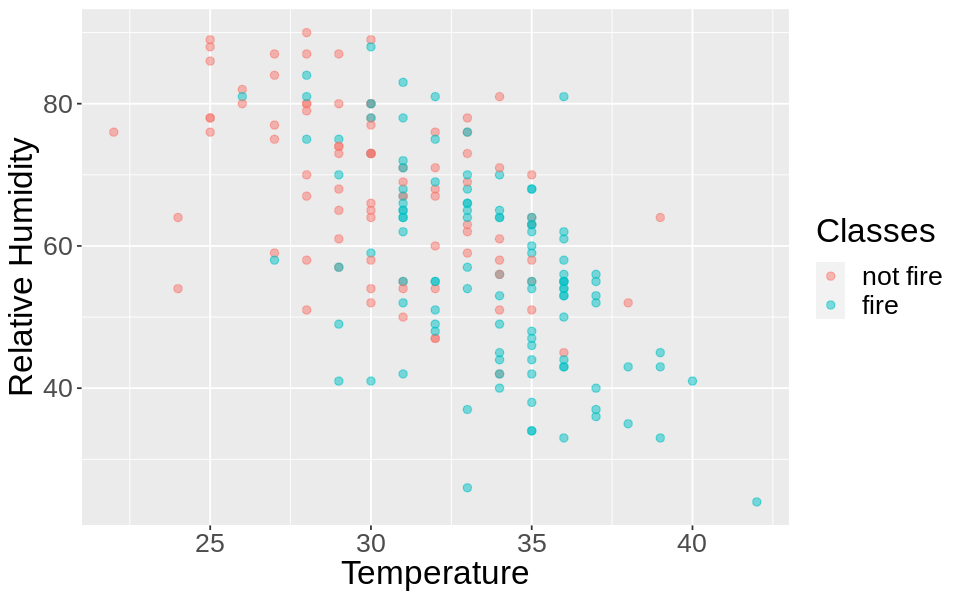

In [13]:
options(repr.plot.width = 8, repr.plot.height = 5)

temp_ws <- frst_fire_train %>%
            ggplot(aes(x = Temperature, y = RH, color = Classes))+
            geom_point(size = 2, alpha = 0.5)+
            labs(x = "Temperature",y = "Relative Humidity", color = "Classes")+
            theme(text = element_text(size = 20))

temp_ws

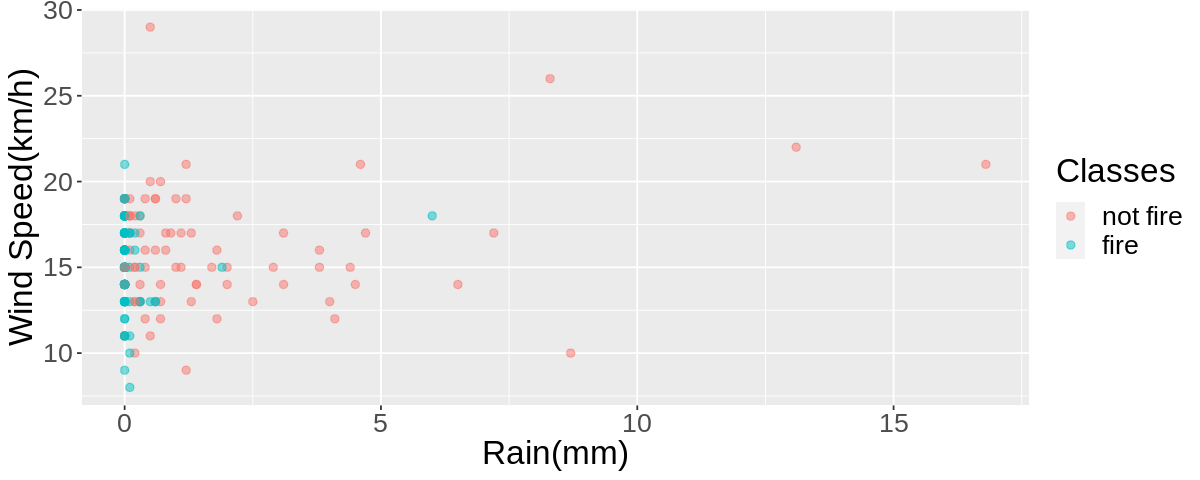

In [14]:
options(repr.plot.width = 10, repr.plot.height = 4)

rain_ws_1 <- frst_fire_train %>%
            ggplot(aes(x = Rain, y = Ws, color = Classes))+
            geom_point(size = 2, alpha = 0.5)+
            labs(x = "Rain(mm)",y = "Wind Speed(km/h)", color = "Classes")+
            theme(text = element_text(size = 20))
rain_ws_1


Looking at this plot and we realized that the data needs to be scaled. 

In [15]:
fire_s_train <- frst_fire_train %>%
                        mutate(scale_temp = scale(Temperature, center = TRUE),
                              scale_RH = scale(RH, center = TRUE),
                              scale_Ws = scale(Ws, center = TRUE),
                              scale_Rain = scale(Rain, center = TRUE))


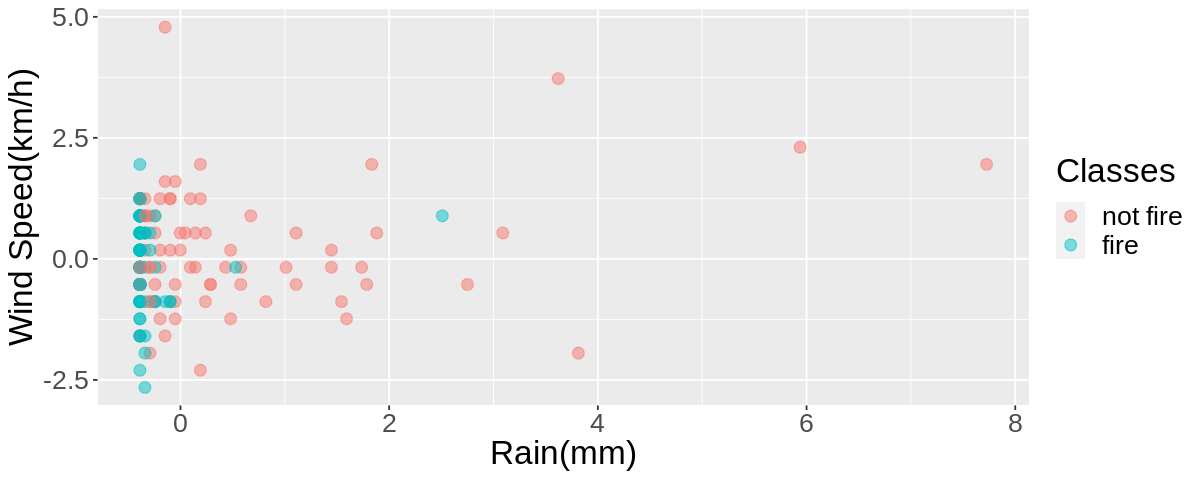

In [16]:
options(repr.plot.width = 10, repr.plot.height = 4)

rain_ws <- fire_s_train %>%
            ggplot(aes(x = scale_Rain, y = scale_Ws, color = Classes))+
            geom_point(size = 3, alpha = 0.5)+
            labs(x = "Rain(mm)",y = "Wind Speed(km/h)", color = "Classes")+
            theme(text = element_text(size = 20))
rain_ws

Method:

We will use the columns from Rain, Temperature, Relative Humidity, and Wind Speed to create several scatter plots in order to visualize the relationships between the vectors. To predict whether or not a forest fire will occur at a new observation, we will use the K-nearest neighbours, create a recipe to scale and center the data, then fit the data to create a prediction.
